<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 7: Neural Networks

**Clemson University**<br>
**Spring 2023**<br>
**Instructor(s):** Carlos Toxtli & Nina Hubig <br>
**Author(s):** Brandon Walker

---

In [15]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and are aiming to teach. And, if a problem specifies a particular library, you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

Instructions for installing Tensorflow using pip https://www.tensorflow.org/install/pip

In [16]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

#from sklearn.utils import shuffle

In [17]:
# TensorFlow and tf.keras
import tensorflow as tf

print(tf.__version__)

2.12.0


<div class='theme'> Neural Networks</div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here, we'll focus on the key idea of ANNs: they are able to learn a mapping from example input data $X$ (of fixed size) to example output data $Y$ (of fixed size). This is the same concept as every other classification and regression task we've learned so far in the semester. We'll also partially explore what patterns the neural network learns and how well neural networks generalize.

In this question, we'll see if neural networks can learn a limited version of the [Fourier Transform.](https://en.wikipedia.org/wiki/Fourier_transform) (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{- i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original $f(x)$ looks like a wave with a period of $s$. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this p-set is this: a function goes in, and a re-written form in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 10$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our `X_train` dataset's shape is $N x 1000$ and our `y_train` is $N x 4.$

Questions 1.1 and 1.2 will get you used to the format of the data. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 x 1,000) and (10,000 x 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 x 1,000) and (2,000 x 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 x 1,000) and (9 x 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

**Hint**:
- The Tensorflow [`tf.keras` (here)](https://www.tensorflow.org/guide/keras) documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [18]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a tf.keras model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])

In [19]:
X_train = np.load('sinewaves_X_train.npy')
y_train = np.load('sinewaves_y_train.npy')

X_test = np.load('sinewaves_X_test.npy')
y_test = np.load('sinewaves_y_test.npy')

X_extended_test = np.load('sinewaves_X_extended_test.npy')
y_extended_test = np.load('sinewaves_y_extended_test.npy')

In [20]:
print(y_test[0])

[0.86199664 0.98175913 0.65523998 0.4870337 ]


<hr style='height:2pt'>

<div class='exercise'> <b> Question 1 </b> </div>
Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

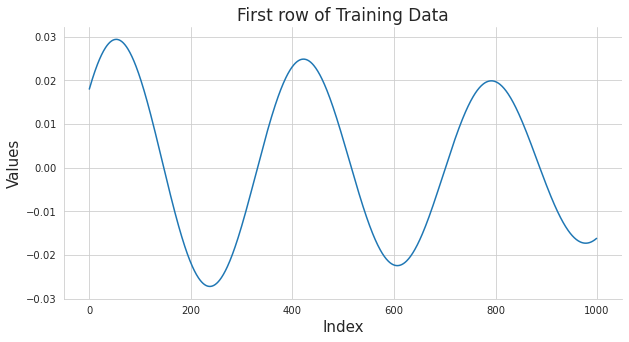

In [21]:
# your code here
with sns.axes_style('whitegrid'):
    size = 15
    plt.figure(figsize=(10,5))
    plt.plot(X_train[0])
    plt.xlabel('Index', size=size)
    plt.ylabel('Values', size=size)
    plt.title('First row of Training Data', size=size+2)
    sns.despine()

<div class='exercise'> <b> Question 2 </b> </div>

The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$

In [22]:
# your code here
# implementation of f(x) = 0.024sin(0.533x) + 0.018cos(0.558x)
def func(params, x_vals):
    a, b, c, d = params
    res = [a * np.sin(b * x) + c * np.cos(d * x) for x in x_vals]
    return res

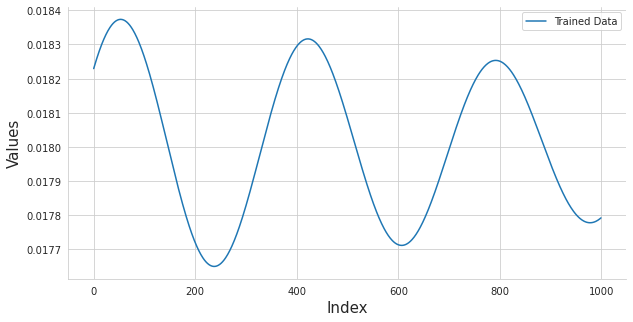

In [23]:
# your code here 
# initialize x as 1000 equally-spaced points in [0,10pi]
x_ori = X_train[0]

# generate y_vals from the given function
y_vals_ori = func(y_train[0], x_ori)

# numerically verify y_vals equals first row of X_train
#if np.array_equal(y_vals_ori, y_vals_ran):
#    print('Equal')
#else:
#    print('Not Equal')

# your code here
with sns.axes_style('whitegrid'):
    size = 15
    plt.figure(figsize=(10,5))
    plt.plot(y_vals_ori, label='Trained Data') # first row of X_train
    plt.xlabel('Index', size=size)
    plt.ylabel('Values', size=size)
    plt.legend()
    sns.despine()

<div class='exercise'> <b> Question 3 </b> </div>
Use `tf.keras` to build a fully-connected neural network:

**a:** Use `tf.keras.models.Sequential` and `tf.keras.layers.Dense` to build the fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. Remember that as a regression problem, the last layer activation should be `linear`.

**b:** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**c:** Fit your model to the data for $50$ epochs using a batch size of $32$ and a validation split of $0.2$. You can train for longer if you wish -- the fit tends to improve over time.


In [24]:
# build the fully-connected neural network
# your code here
from keras.models import Sequential
from keras.layers import Activation, Dense

H = 25
input_dim = X_train.shape[1]
# instantiate a Sequential model
model = Sequential()
# add layer 0
model.add(Dense(H, input_dim=input_dim, activation='relu'))
# add layer 1
model.add(Dense(H, activation='tanh'))
# add layer 2
model.add(Dense(H, activation='sigmoid'))
# add layer 3
model.add(Dense(4, activation='linear'))

In [25]:
# Compile your model 
# your code here
model.compile(loss='mean_absolute_error', optimizer='adam')
# display model summary
model.summary()

#The first layer in my network has 25025 parameters. This is obtained as:
#1000 (Input values to the first layer) * 25 (Number of nodes/weight values in the first layer) + 25
#(Bias weight values) = 30030 parameters

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 25)                25025     
                                                                 
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dense_6 (Dense)             (None, 25)                650       
                                                                 
 dense_7 (Dense)             (None, 4)                 104       
                                                                 
Total params: 26,429
Trainable params: 26,429
Non-trainable params: 0
_________________________________________________________________


*your answer here*
There are 25025 params in the first layer. This is due to we have around 10000 values as input.



In [26]:
# Fit your model 
# your code here
model_history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=False, shuffle=True, validation_split=0.2)

<div class='exercise'> <b> Question 4 </b> </div>

Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

63/63 [==============================] - 0s 1ms/step


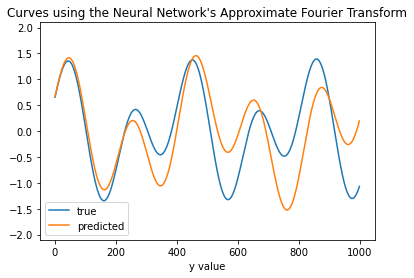

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.8683273  0.98177207 0.66643435 0.4004845 ]


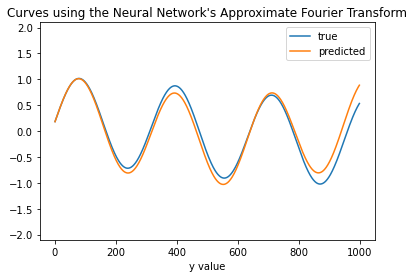

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.84845525 0.6332973  0.18192047 0.18143128]


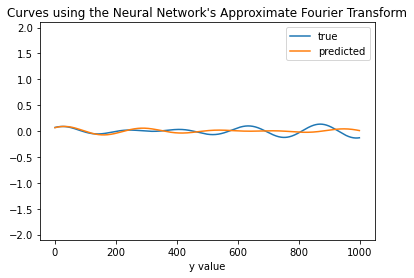

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.06576827 0.7312938  0.06599224 0.8063954 ]


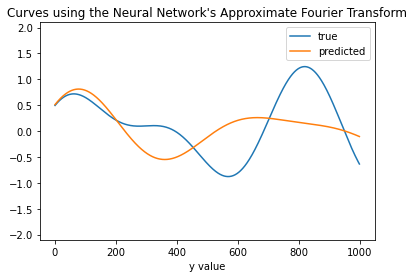

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.7144063  0.33190486 0.5113783  0.39243773]


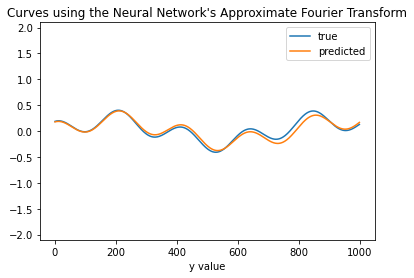

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.21504425 0.25888258 0.17724818 0.9429369 ]


In [27]:
# your code here
plot_predictions(model, X_test, y_test)

In [28]:
# model's overall loss
# your code here
# generate model's predictions on test set
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)
# calculate mean absolute error on the test set
loss = np.sum(np.abs(y_pred - y_test))/y_test.shape[0]
# calculate r2 score on the test set
r2_score = r2_score(y_test, y_pred)

print('Mean absolute error (test set) is {:.4f}'.format(loss))
print('R2 score (test set) is {:4f}'.format(r2_score))

63/63 [==============================] - 0s 1ms/step
Mean absolute error (test set) is 0.1247
R2 score (test set) is 0.951110


*your answer here*
...

----

<div class='exercise'> <b> Question 5 </b> </div>
Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

1/1 [==============================] - 0s 18ms/step


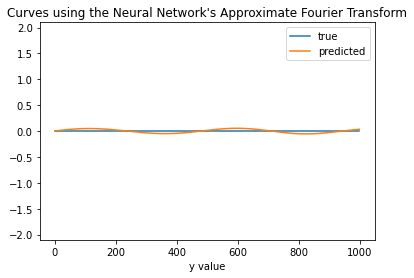

true: [0. 0. 0. 0.]
predicted: [0.05155779 0.42206326 0.00352094 0.631369  ]


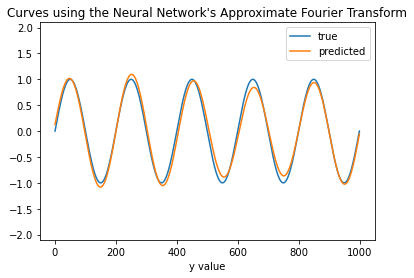

true: [1. 1. 0. 0.]
predicted: [0.97003955 0.9954223  0.1273456  0.77220327]


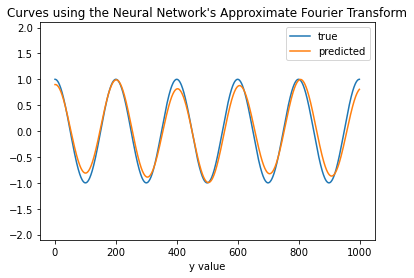

true: [0. 0. 1. 1.]
predicted: [0.10249829 0.32022163 0.89816755 0.99162227]


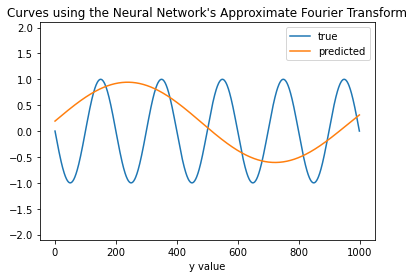

true: [-1.  1.  0.  0.]
predicted: [ 0.7558228   0.20850593  0.19303572 -0.03019819]


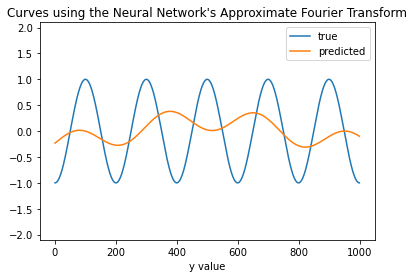

true: [ 0.  0. -1.  1.]
predicted: [ 0.22092934  0.6796122  -0.23215066 -0.19912323]


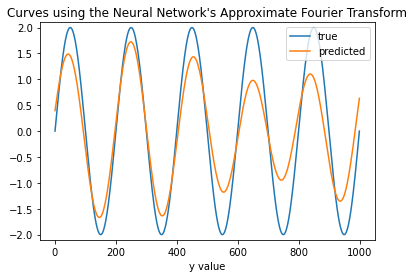

true: [2. 1. 0. 0.]
predicted: [1.3295077  1.0058341  0.3949278  0.79517955]


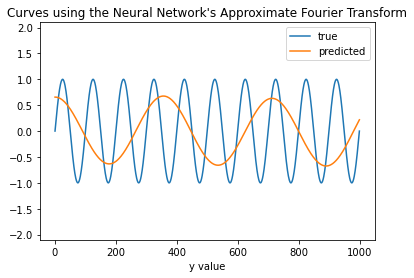

true: [1. 2. 0. 0.]
predicted: [-0.02511884 -0.19498162  0.65618235  0.560979  ]


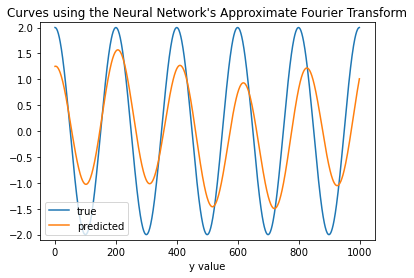

true: [0. 0. 2. 1.]
predicted: [0.31933916 0.2382883  1.2499119  0.96929216]


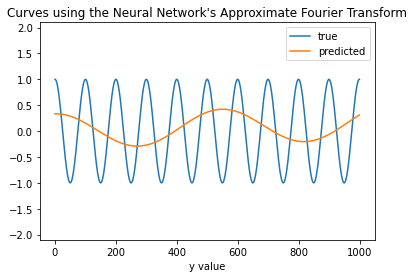

true: [0. 0. 1. 2.]
predicted: [0.35836172 0.0144158  0.33365425 0.3653545 ]


In [29]:
# your code here
plot_predictions(model, X_extended_test, y_extended_test, count=9)

In [30]:
from sklearn.metrics import r2_score

# generate model's predictions on the extended test set
y_pred_extended = model.predict(X_extended_test)
# calculate mean absolute error on the extended test set
loss_extended = np.sum(np.abs(y_pred_extended - y_extended_test))/y_extended_test.shape[0]
# calculate r2 score on the extended test set
r2_score_extended = r2_score(y_extended_test, y_pred_extended)

print('Mean absolute error (extended test set) is {:.4f}'.format(loss_extended))
print('R2 score (extended test set) is {:4f}'.format(r2_score_extended))

1/1 [==============================] - 0s 20ms/step
Mean absolute error (extended test set) is 2.0588
R2 score (extended test set) is -0.024963


*Your answer here*
After evaluating the model performance on 9 pairs, model two worked well and model 4 has struggled.

----

<div class='exercise'> <b> Question 6 </b> </div>
Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

*Your answer here*

### Answer
High frequency of the actual underlying functions seems to be the most distinctive feature in
observations where the model performs the poorest. It seems that the model is mostly trained on
relatively low-frequency functions, and as a result, it struggles with high frequency observations in
test data. Upon inspection of the test data (on which the model performed fairly well), we observe
a mix of high and low frequency observations. In the extended test set however, we mostly
observe high frequency functions, on which the model performs incredibly poorly.
It wouldn't be accurate to categorize the model as overfit based on poor performance on the
extended test set because it's small and it doesn't seem to be terribly representative of the entire
data distribution (since it almost exclusively contains high frequency observations). Overfitting
refers to a failure in generalizability, and based on the (relatively more representative) test set, the
model does seem to generalize fairly well. The model is also not underfit since it seems to capture
the patterns in the distribution of the test set fairly well.
Based on the above, I'd claim that the model is neither underfit nor overfit and is overall fairly
good.